In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

In [7]:
grid_sun = np.load('data/solar_grid.npy')
grid_18sco = np.load('data/18sco_grid.npy')
wl = np.load('data/solar_grid_wl.npy')

(2025, 8999)


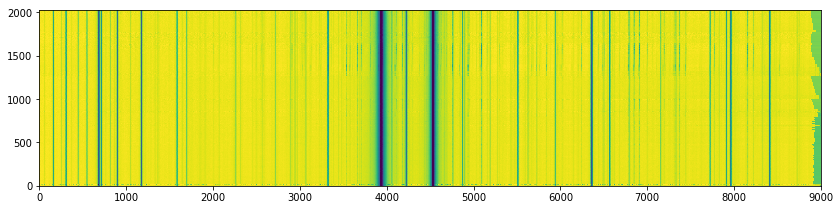

(2914, 8999)


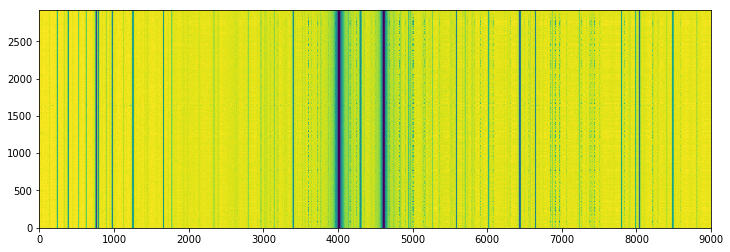

In [10]:
for grid in [grid_sun, grid_18sco]: 
    print(grid.shape)
    plt.figure(figsize=(14, 4))
    plt.imshow(grid, vmin=0.2, vmax=1.01, origin='lower')
    plt.show()

In [11]:
median_sun = np.median(grid_sun, axis=0)
median_18sco = np.median(grid_18sco, axis=0)

Shift wavelength solution of 18 Sco

In [14]:
cross_corr = np.correlate(median_sun - np.median(median_sun), 
                          median_18sco - np.median(median_18sco), mode='same')

dx = cross_corr.shape[0]//2 - cross_corr.argmax()

In [47]:
# plt.figure(figsize=(14, 10))
# plt.plot(wl, median_sun)
# plt.plot(wl, shifted_18sco)
# plt.show()

In [94]:
from scipy.optimize import fmin_l_bfgs_b, fmin_powell
from scipy.interpolate import interp1d

shifted_18sco = np.roll(median_18sco, -dx)

roll_range = np.arange(-10, 10)

def minfunc(p): 
    f = interp1d(p[0] + p[1]*wl, shifted_18sco, bounds_error=False, fill_value=0)
    rolled_spectral_grid = f(wl)
    return np.sum((median_sun - rolled_spectral_grid)**2)

bounds = [[-1, 1], 
          [-1, 1]]

# result = fmin_l_bfgs_b(minfunc, [0.3, 0.9999], bounds=bounds, approx_grad=True)

result = [fmin_powell(minfunc, [0.3, 0.9999])]#

f = interp1d(result[0][0] + result[0][1]*wl, shifted_18sco, bounds_error=False, fill_value=0)
shifted_18sco = f(wl)

Optimization terminated successfully.
         Current function value: 5.843199
         Iterations: 2
         Function evaluations: 121


Remove tellurics

In [522]:
# p = [-0.5, 1.0, 3]
# f = interp1d(p[0] + p[1]*wl_tellurics, gaussian_filter1d(tellurics, p[2]), bounds_error=False, fill_value=0)
# rolled_spectral_grid = f(wl)

# plt.plot(median_sun)
# plt.plot(rolled_spectral_grid)
# plt.plot()

In [141]:
from astropy.io import fits

arcturus = fits.getdata('/Users/bmmorris/Desktop/whoseline/arcturus_atlas/visual/ardata.fits')

In [301]:
from scipy.optimize import fmin_l_bfgs_b, fmin_powell
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

wl_tellurics = arcturus['WAVELENGTH']
tellurics = arcturus['TELLURIC'][(wl_tellurics > wl.min()) & (wl_tellurics < wl.max())]
wl_tellurics = arcturus['WAVELENGTH'][(wl_tellurics > wl.min()) & (wl_tellurics < wl.max())]
wl_tellurics = wl_tellurics[tellurics > 0] - 0.54
tellurics = tellurics[tellurics > 0]

tellurics_interp = interp1d(wl_tellurics, tellurics, bounds_error=False)(wl)

In [533]:
shifted_tellurics = gaussian_filter1d(tellurics_interp, 2.9) #np.roll(tellurics_interp, -dx)

from scipy.optimize import fmin_powell, fmin_l_bfgs_b

wl_bounds_sun = ((wl < 5919.5) & (wl > 5918.8))

# wl_bounds_18sco = ((wl < 5920) & (wl > 5919))


def minfunc_sun(p):
#     print(p)
    shifted_tellurics = gaussian_filter1d(np.interp(wl[wl_bounds_sun], wl-p[1], tellurics_interp - p[2]), abs(p[0]))
    renormalized = median_sun[wl_bounds_sun] / shifted_tellurics
    renormalized -= np.nanmedian(renormalized)
    return np.nansum(renormalized**2)

def minfunc_18sco(p, offset, sigma):
    shifted_tellurics = gaussian_filter1d(np.interp(wl[wl_bounds_sun], wl-p[0], tellurics_interp - offset), sigma)
    renormalized = shifted_18sco[wl_bounds_sun] / shifted_tellurics
    
#     plt.plot(wl[wl_bounds_sun], shifted_18sco[wl_bounds_sun])
#     plt.plot(wl[wl_bounds], shifted_tellurics)
#     plt.xlim([5918, 5920])
#     plt.show()
    
    renormalized -= np.nanmedian(renormalized)
    return np.nansum(renormalized**2)

results_sun = [fmin_powell(minfunc_sun, [1.9, 0.001, -0.3], disp=0)]#, bounds=[[0.01, 100], [-1, 1]])
print(results_sun)

sigma, offset = results[0][0], results[0][1]
results_18sco = [fmin_powell(minfunc_18sco, [0.15], disp=0, args=(offset, sigma))]#, bounds=[[0.01, 100], [-1, 1]])
print(results_18sco)

[array([ 1.95842369e+00,  1.64755174e-03, -3.21170217e-01])]
[array(0.14787914)]


(5910, 5930)

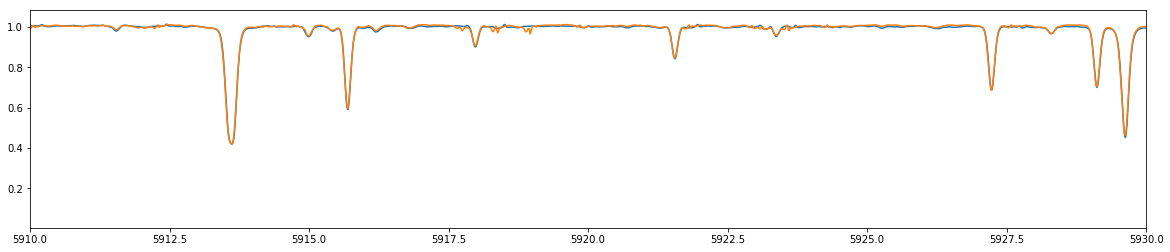

In [535]:
shifted_tellurics = gaussian_filter1d(np.interp(wl, wl-results_sun[0][1], tellurics_interp - results_sun[0][2]), abs(results_sun[0][0]))
sun_tellurics_corrected = median_sun / shifted_tellurics 
sun_tellurics_corrected /= np.nanmedian(sun_tellurics_corrected)

shifted_tellurics = gaussian_filter1d(np.interp(wl, wl-results_18sco[0], tellurics_interp - results_sun[0][2]), abs(results_sun[0][0]))
sco_tellurics_corrected = shifted_18sco / shifted_tellurics 
sco_tellurics_corrected /= np.nanmedian(sco_tellurics_corrected)

plt.figure(figsize=(20, 4))
plt.plot(wl, sun_tellurics_corrected)
plt.plot(wl, sco_tellurics_corrected)
# plt.ylim([0.8, 1.015])
plt.xlim([5910, 5930])

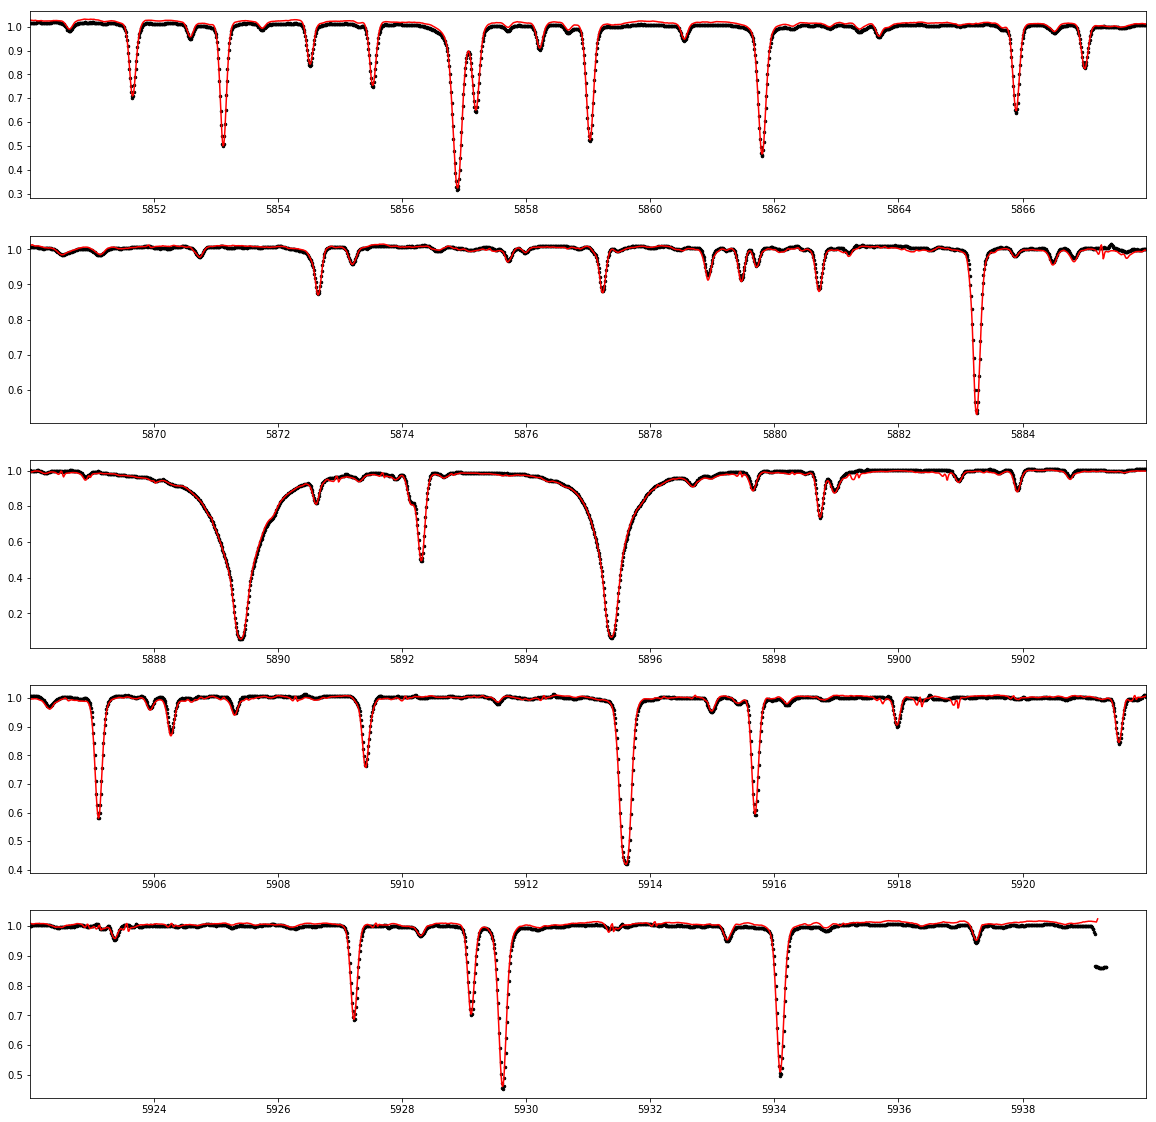

In [536]:
fig, ax = plt.subplots(5, 1, figsize=(20, 20))

for i, inds in enumerate(np.split(np.arange(len(wl)+1), 5)):
    inds = inds[:-1]
    ax[i].plot(wl[inds], sun_tellurics_corrected[inds], '.k', ms=5)
    ax[i].plot(wl[inds], sco_tellurics_corrected[inds], color='r')

#     ax[i].plot(wl[inds], shifted_18sco[inds] - median_sun[inds] + 1, color='DodgerBlue', ms=5)

#     inbounds = (wl[inds].max() > arcturus['WAVELENGTH']) & (wl[inds].min() < arcturus['WAVELENGTH'])
#     wl_tellurics, tellurics = arcturus['WAVELENGTH'][inbounds], arcturus['TELLURIC'][inbounds]
#     tellurics[tellurics < 0] = 1
#     ax[i].plot(wl_tellurics - 0.55, tellurics, color='gray')
    
    ax[i].set_xlim([wl[inds].min(), wl[inds].max()])
    
plt.savefig('plots/overlap.png', bbox_inches='tight', dpi=250)
# plt.plot(wl, median_sun - shifted_18sco)

(-0.05, 0.2)

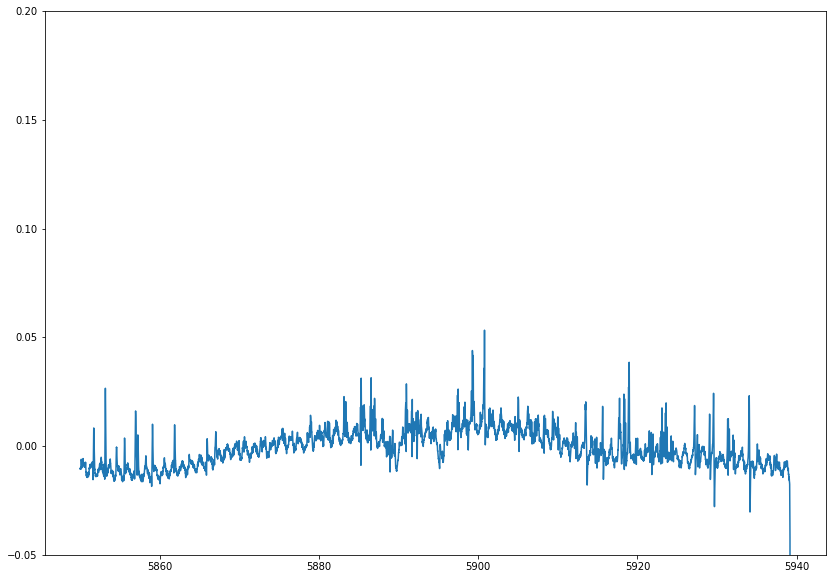

In [537]:
plt.figure(figsize=(14, 10))
plt.plot(wl, sun_tellurics_corrected - sco_tellurics_corrected)
plt.ylim([-0.05, 0.2])